In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.metrics import r2_score, mean_absolute_error

import shap
import xgboost

from training_models import *


In [133]:
train_data_file_path = '../data/data_ready_for_models/DerateInNextTwentyFourHours_kneighbors_05_13_train.csv'
test_data_file_path = '../data/data_ready_for_models/DerateInNextTwentyFourHours_kneighbors_05_13_test.csv'

train_df = pd.read_csv(train_data_file_path)#.drop(columns='Unnamed: 0')
test_df = pd.read_csv(test_data_file_path)#.drop(columns='Unnamed: 0')


C:\Users\irela\AppData\Local\Temp\ipykernel_23580\205940278.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_data_file_path)#.drop(columns='Unnamed: 0')


In [71]:
ple = test_df.head()

In [134]:

train_df = train_df.drop(columns='LampStatus')
test_df = test_df.drop(columns='LampStatus')

train_df = train_df.dropna()
test_df = test_df.dropna()

test_df_copy = test_df.copy()

train_df = ensure_target_cols_removed(train_df)
test_df = ensure_target_cols_removed(test_df)

def split_X_y(df):
    """
    Splits the DataFrame into features (X) and target (y).
    Assumes the first column is the target variable.
    """
    y = df.iloc[:, 0]
    X = df.iloc[:, 1:]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [73]:
y_test.head()

1    0
2    0
3    0
4    0
5    0
Name: DerateInNextTwentyFourHours, dtype: int64

In [79]:
#xgb = xgboost.XGBRegressor(tree_method="hist", enable_categorical = True).fit(X_train, y_train)
xgb = xgboost.XGBClassifier().fit(X_train, y_train)
#logreg = LogisticRegression().fit(X_train, y_train)

2025/05/13 17:56:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f5ebce7840e94ca697cda208b69d9aed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/05/13 17:56:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\irela\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <http

In [86]:
def start_mlflow_run(train_data_file_path, test_data_file_path, predictions_filepath, model, dropna=True):
    """
    Starts an MLflow run and logs the parameters and artifacts.
    """
    mlflow.set_experiment("big-g-haulin-oats")
    mlflow.autolog()

    with mlflow.start_run():
        mlflow.log_param("train_data_file_path", train_data_file_path)
        mlflow.log_param("test_data_file_path", test_data_file_path)

        mlflow.log_artifact(train_data_file_path, artifact_path="data")
        mlflow.log_artifact(test_data_file_path, artifact_path="data")

        train_data_file_path = '../data/data_ready_for_models/DerateInNextTwentyFourHours_kneighbors_05_13_train.csv'
        test_data_file_path = '../data/data_ready_for_models/DerateInNextTwentyFourHours_kneighbors_05_13_test.csv'

        train_df = pd.read_csv(train_data_file_path)#.drop(columns='Unnamed: 0')
        test_df = pd.read_csv(test_data_file_path)#.drop(columns='Unnamed: 0')

        train_df = train_df.drop(columns='LampStatus')
        test_df = test_df.drop(columns='LampStatus')

        train_df = train_df.dropna()
        test_df = test_df.dropna()

        copy_test_df = test_df.copy()

        train_df = ensure_target_cols_removed(train_df)
        test_df = ensure_target_cols_removed(test_df)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics on the test set
        precision, recall, f1, accuracy = evaluate_model(y_test, y_pred)
        print(f"Test precision: {precision}")
        print(f"Test recall: {recall}")
        print(f"Test F1 score: {f1}")
        print(f"Test accuracy: {accuracy}")
        # Log custom metrics for the test set
        mlflow.log_metric("test_precision", precision)
        mlflow.log_metric("test_recall", recall)
        mlflow.log_metric("test_f1", f1)
        mlflow.log_metric("test_accuracy", accuracy)

        print("Model training and evaluation completed successfully.")

        # Save predictions to a CSV file
        predictions_df = pd.DataFrame({
            'Actual': y_test,
            'Predicted': y_pred
        })
        predictions_df.to_csv(predictions_filepath, index=False)
        mlflow.log_artifact(predictions_filepath, artifact_path="data")

    return predictions_df

In [87]:
predictions_filepath = '../data/model_output/this_time_please_work_preds.csv'
model = xgboost.XGBClassifier()

pred_df = start_mlflow_run(train_data_file_path, test_data_file_path, predictions_filepath, model)

2025/05/13 18:00:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/13 18:00:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/05/13 18:00:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
C:\Users\irela\AppData\Local\Temp\ipykernel_23580\1272376556.py:18: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_data_file_path)#.drop(columns='Unnamed: 0')
2025/05/13 18:00:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\irela\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is t

Test precision: 0.6598639455782312
Test recall: 0.2650273224043716
Test F1 score: 0.37816764132553604
Test accuracy: 0.996972860125261
Model training and evaluation completed successfully.


In [89]:
pred_df.head()

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
test_df_copy.head()

In [94]:
def count_predictions(predictions_df, test_df, num_prev_hours=24):

    df = pd.merge(predictions_df, test_df.dropna().reset_index(), left_index=True, right_index=True)
    df['EventTimeStamp'] = pd.to_datetime(df['EventTimeStamp'])
    df = df.sort_values('EventTimeStamp').reset_index(drop=True)

    # If Predicted == 1 and FullDerate occurs at least 2 hours later and less than 24 hours later, True Positive count ++
    df['NextDerateTime'] = np.where(df['FullDerate']==1, df['EventTimeStamp'], pd.NaT)
    df['NextDerateTime'] = pd.to_datetime(df['NextDerateTime'])
    df['NextDerateTime'] = df['NextDerateTime'].bfill()

    df['HoursUntilNextDerate'] = (df['NextDerateTime'] - df['EventTimeStamp']).dt.total_seconds() / 3600.0
    df['TruePositive'] = np.where(((df['HoursUntilNextDerate'] > 2) & (df['HoursUntilNextDerate'] <= num_prev_hours) & (df['Actual']==1) & (df['Predicted']==1)), 1, 0)
    df['FalsePositive'] = np.where(((df['Actual']==0) & (df['Predicted']==1)), 1, 0)

    df['CountedTruePositive'] = 0
    df['CountedFalsePositive'] = 0

    full_derates = df[df['FullDerate'] == 1]['EventTimeStamp'].tolist()

    for derate_time in full_derates:
        window_start = derate_time - pd.Timedelta(hours=num_prev_hours)
        tp_mask = (
            (df['EventTimeStamp'] >= window_start) &
            (df['EventTimeStamp'] < derate_time) &
            (df['TruePositive'] == 1)
        )
        if tp_mask.any():
            first_tp_index = df[tp_mask].index[0]
            df.loc[first_tp_index, 'CountedTruePositive'] = 1

    last_counted_fp_time = pd.Timestamp('1900-01-01')

    for i, row in df.iterrows():
        if row['FalsePositive'] == 1:
            if row['EventTimeStamp'] - last_counted_fp_time >= pd.Timedelta(hours=num_prev_hours):
                df.at[i, 'CountedFalsePositive'] = 1
                last_counted_fp_time = row['EventTimeStamp']

    tp_count = df['CountedTruePositive'].sum()
    fp_count = df['CountedFalsePositive'].sum()

    print(f'True Positives: {tp_count}')
    print(f'False Positives: {fp_count}')

    return tp_count, fp_count, df

In [95]:
revenue_tp, revenue_fp, df = count_predictions(pred_df, test_df_copy)
total_revenue = revenue_calc(revenue_tp, revenue_fp)

True Positives: 1
False Positives: 26
Total revenue: -9000


In [136]:
def plot_feature_explainer(fitted_model, X_test, plot_type, model_type=None, i=None, feature_col_name=None):
    if model_type=='tree':
        explainer = shap.explainers.Tree(fitted_model)
    elif model_type=='linear':
        explainer = shap.explainers.Linear(fitted_model, X_test)
    else:
        raise ValueError("Please spedcify model type as 'linear' or 'tree'.")

    explanation = explainer(X_test)

    def waterfall_plot(i):
        shap.plots.waterfall(explanation[i])

    def force_plot(i):
        shap.plots.initjs()
        shap.plots.force(explanation[i])

    def global_predictions_plot(feature_col_name):
        shap.plots.scatter(explanation[:, feature_col_name], color=explanation)

    def beeswarm_plot():
        shap.plots.beeswarm(explanation)

    def avg_bar_plot():
        shap.plots.bar(explanation)

    if i is None and (plot_type == 'waterfall' or plot_type == 'force_plot'):
        raise ValueError('Must specify which feature i you want to plot.')
    else:
        if plot_type == 'waterfall':
            print('Plotting waterfall plot...')
            waterfall_plot(i)
        elif plot_type == 'force_plot':
            print('Plotting force plot...')
            force_plot(i)
        elif plot_type == 'global_predictions':
            print('Plotting global predictions plot...')
            global_predictions_plot(feature_col_name)
        elif plot_type == 'beeswarm':
            print('Plotting beeswarm plot...')
            beeswarm_plot()
        elif plot_type == 'avg_bar':
            print('Plotting average bar plot...')
            avg_bar_plot()
        else:
            raise ValueError("Error: plot_type must be 'waterfall', 'force_plot', 'global_predictions', 'beeswarm', or 'avg_bar'.")


In [ ]:
test_df_copy.head()

In [97]:
tp, fp, df = count_predictions(pred_df, test_df_copy)

df.head()

True Positives: 1
False Positives: 26


,Actual,Predicted,index,DerateInNextTwentyFourHours,EventTimeStamp,spn,EquipmentID,BarometricPressure,DistanceLtd,EngineCoolantTemperature,...,fmi_6,fmi_7,fmi_8,fmi_9,NextDerateTime,HoursUntilNextDerate,TruePositive,FalsePositive,CountedTruePositive,CountedFalsePositive
0,0,0,4514,0,2019-01-01 00:24:10,111,1746,0.144928,0.929413,-2.919524,...,0.0,0.0,0.0,0.0,2019-01-13 21:21:37,308.957500,0,0,0,0
1,0,0,4515,0,2019-01-01 00:36:08,111,1746,0.247822,0.040950,-0.090375,...,0.0,0.0,0.0,0.0,2019-01-13 21:21:37,308.758056,0,0,0,0
2,0,0,9601,0,2019-01-01 01:54:35,111,1777,-0.140890,1.113921,-1.713298,...,0.0,0.0,0.0,0.0,2019-01-13 21:21:37,307.450556,0,0,0,0
3,0,0,9602,0,2019-01-01 02:08:21,111,1777,0.247822,0.040950,-0.090375,...,0.0,0.0,0.0,0.0,2019-01-13 21:21:37,307.221111,0,0,0,0
4,0,0,4074,0,2019-01-01 03:06:52,2863,1741,0.030601,1.018398,0.425012,...,0.0,1.0,0.0,0.0,2019-01-13 21:21:37,306.245833,0,0,0,0


In [121]:
df[(df['CountedFalsePositive']==1) & (df['Actual']==0)]

,Actual,Predicted,index,DerateInNextTwentyFourHours,EventTimeStamp,spn,EquipmentID,BarometricPressure,DistanceLtd,EngineCoolantTemperature,...,fmi_6,fmi_7,fmi_8,fmi_9,NextDerateTime,HoursUntilNextDerate,TruePositive,FalsePositive,CountedTruePositive,CountedFalsePositive
1499,0,1,5555,0,2019-01-06 21:08:17,4094,1749,0.487910,1.015550,-0.890871,...,0.0,0.0,0.0,0.0,2019-01-13 21:21:37,168.222222,0,1,0,1
3332,0,1,103896,0,2019-01-11 06:45:46,5114,303,0.202092,-0.408603,-2.590553,...,0.0,0.0,0.0,1.0,2019-01-13 21:21:37,62.597500,0,1,0,1
10334,0,1,4655,0,2019-01-30 18:56:54,5109,1747,0.030601,1.106337,-0.945699,...,0.0,0.0,0.0,0.0,2019-01-31 21:23:21,26.440833,0,1,0,1
11839,0,1,96567,0,2019-02-04 14:09:30,6147,2204,0.030601,-2.070330,0.370184,...,0.0,0.0,0.0,0.0,2019-02-05 03:22:15,13.212500,0,1,0,1
13585,0,1,60211,0,2019-02-08 17:15:36,6802,1973,0.316419,-0.413845,-4.180579,...,0.0,0.0,0.0,0.0,2019-02-14 13:46:15,140.510833,0,1,0,1
22653,0,1,47372,0,2019-03-03 08:33:36,3251,1939,0.259255,-0.084502,0.260527,...,0.0,0.0,0.0,0.0,2019-03-08 13:48:13,125.243611,0,1,0,1
23721,0,1,4908,0,2019-03-05 17:28:10,5109,1747,0.030601,1.177267,-0.890871,...,0.0,0.0,0.0,0.0,2019-03-08 13:48:13,68.334167,0,1,0,1
24701,0,1,4939,0,2019-03-08 09:07:18,5109,1747,0.087764,1.185007,-0.945699,...,0.0,0.0,0.0,0.0,2019-03-08 13:48:13,4.681944,0,1,0,1
25920,0,1,97287,0,2019-03-12 11:35:36,5902,2217,0.373583,-2.095006,-2.645382,...,0.0,0.0,0.0,0.0,2019-03-25 11:55:47,312.336389,0,1,0,1
26896,0,1,47440,0,2019-03-15 09:48:46,3251,1939,0.202092,-0.058768,-2.700210,...,0.0,0.0,0.0,0.0,2019-03-25 11:55:47,242.116944,0,1,0,1


In [103]:
X_test.head()

,spn,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,FuelLtd,FuelRate,...,fmi_23,fmi_29,fmi_3,fmi_31,fmi_4,fmi_5,fmi_6,fmi_7,fmi_8,fmi_9
0,639,-0.083727,-1.773036,0.425012,2.245062,-0.347159,0.665821,0.083608,-1.467354,1.758763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,639,-0.083727,-1.773036,0.425012,2.245062,-0.347159,0.665821,0.083608,-1.467354,1.758763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,639,0.042033,-0.492389,0.414046,0.570266,-0.003011,0.244141,0.508414,0.752970,0.393622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,639,-0.072294,0.681236,-2.480896,-0.769570,-0.034297,-0.509773,-0.505624,0.878768,0.297097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37,-0.140890,-1.760107,0.260527,-0.546264,-1.077171,0.077285,-0.961853,-1.458221,-0.686541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
test_df_copy.head()

,DerateInNextTwentyFourHours,EventTimeStamp,spn,EquipmentID,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,...,fmi_23,fmi_29,fmi_3,fmi_31,fmi_4,fmi_5,fmi_6,fmi_7,fmi_8,fmi_9
0,0,2019-01-08 19:39:29,639,105338729,-0.083727,-1.773036,0.425012,2.245062,-0.347159,0.665821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2019-01-08 19:39:29,639,105338729,-0.083727,-1.773036,0.425012,2.245062,-0.347159,0.665821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,2019-01-08 19:42:39,639,105338729,0.042033,-0.492389,0.414046,0.570266,-0.003011,0.244141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2019-01-08 19:42:39,639,105338729,-0.072294,0.681236,-2.480896,-0.769570,-0.034297,-0.509773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,2019-01-16 19:41:28,37,105338729,-0.140890,-1.760107,0.260527,-0.546264,-1.077171,0.077285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
test_df_copy[test_df_copy['EventTimeStamp']=='2019-09-29 23:56:41']

,DerateInNextTwentyFourHours,EventTimeStamp,spn,EquipmentID,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,...,fmi_23,fmi_29,fmi_3,fmi_31,fmi_4,fmi_5,fmi_6,fmi_7,fmi_8,fmi_9
50249,1,2019-09-29 23:56:41,1761,1947,0.373583,0.266525,0.479841,-0.349229,-0.868596,0.133186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50250,1,2019-09-29 23:56:41,1761,1947,0.373583,0.266525,0.479841,-0.349229,-0.868596,0.133186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50251,1,2019-09-29 23:56:41,3364,1947,0.373583,0.266525,0.479841,-0.349229,-0.868596,0.133186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [137]:
plot_feature_explainer(xgb, X_test, plot_type='waterfall', model_type='tree', i=3)


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'module'>

Plotting waterfall plot...


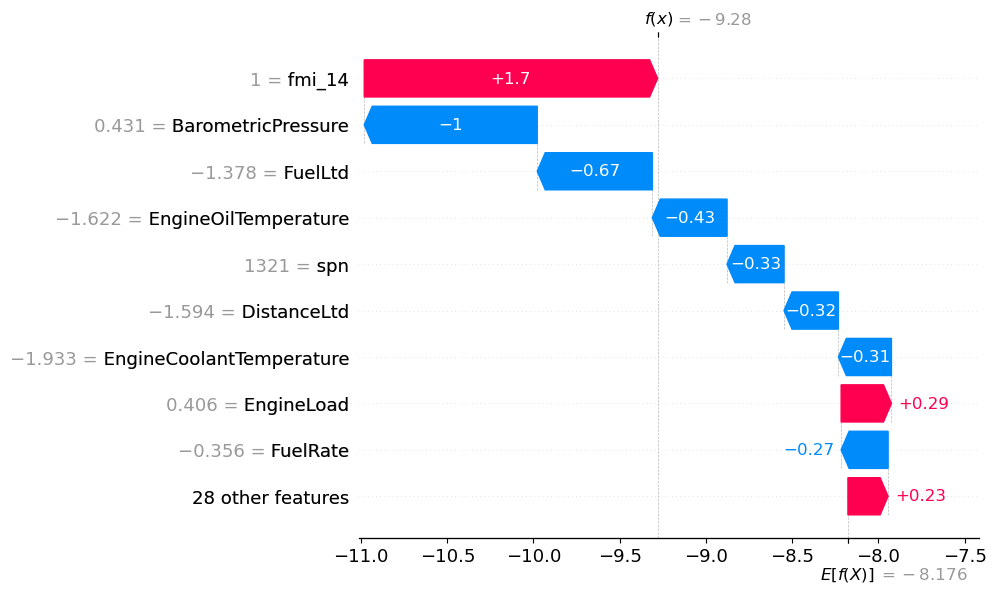

In [119]:
plot_feature_explainer(xgb, X_test, plot_type='waterfall', model_type='tree', i=502)

Plotting waterfall plot...


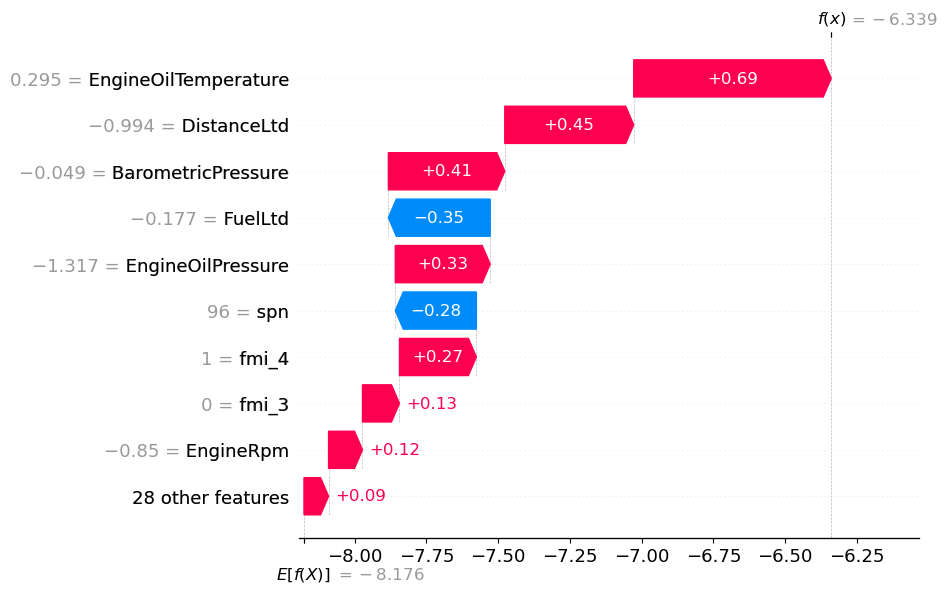

In [111]:
plot_feature_explainer(xgb, X_test, plot_type='waterfall', model_type='tree', i=1943)

Plotting global predictions plot...


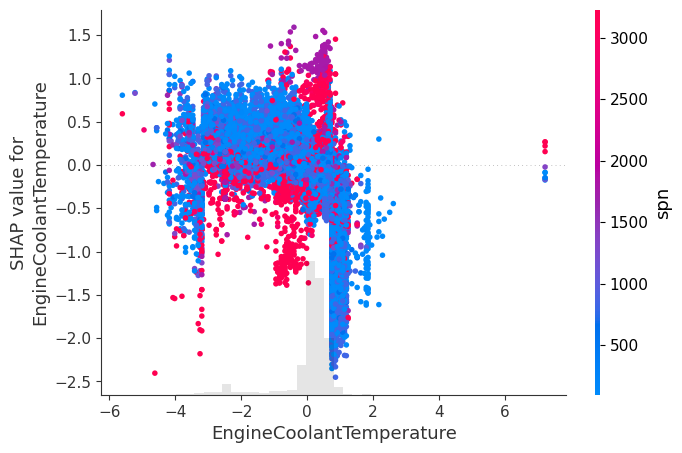

In [112]:
plot_feature_explainer(xgb, X_test, plot_type='global_predictions', model_type='tree', feature_col_name='EngineCoolantTemperature')

Plotting global predictions plot...


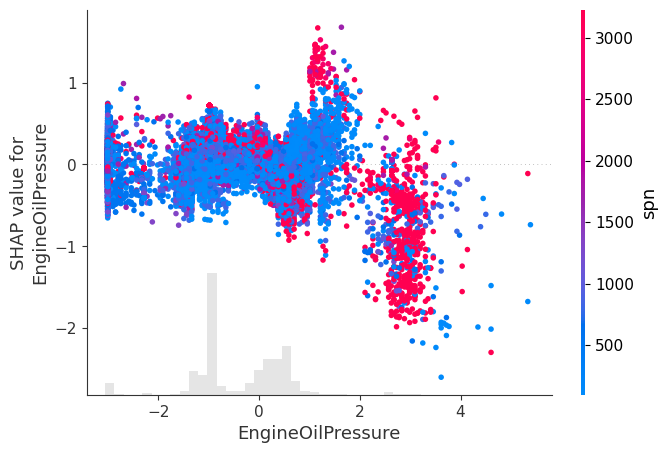

In [123]:
plot_feature_explainer(xgb, X_test, plot_type='global_predictions', model_type='tree', feature_col_name='EngineOilPressure')

Plotting global predictions plot...


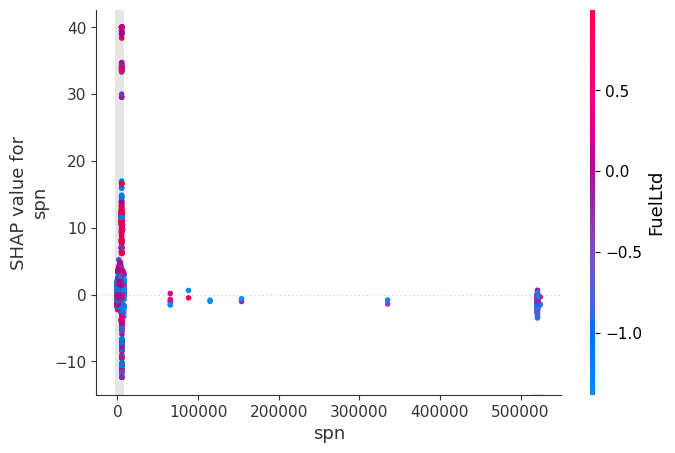

In [118]:
plot_feature_explainer(xgb, X_test, plot_type='global_predictions', model_type='tree', feature_col_name='spn')

Plotting beeswarm plot...


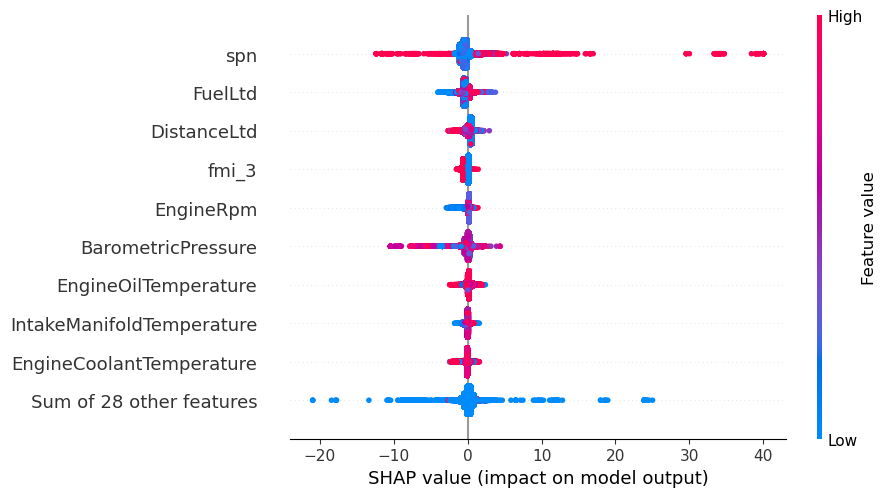

In [114]:
plot_feature_explainer(xgb, X_test, plot_type='beeswarm', model_type='tree')

In [117]:
feature_names = [i for i in X_test.columns.to_list()]
importances = xgb.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                      Feature  Gini Importance
11                      fmi_0         0.657200
12                      fmi_1         0.209293
0                         spn         0.033559
30                     fmi_31         0.031592
36                      fmi_9         0.022620
18                     fmi_15         0.010625
19                     fmi_16         0.004945
1          BarometricPressure         0.004933
22                     fmi_19         0.004183
29                      fmi_3         0.002633
20                     fmi_17         0.002237
21                     fmi_18         0.002057
6        EngineOilTemperature         0.002014
31                      fmi_4         0.001540
2                 DistanceLtd         0.001377
14                     fmi_11         0.001272
8                     FuelLtd         0.001249
17                     fmi_14         0.000985
9                    FuelRate         0.000808
3    EngineCoolantTemperature         0.000792
5           E

In [126]:
import pickle
import joblib
import os
from pathlib import Path
from datetime import datetime
Path('xgb_model').mkdir(exist_ok=True)
Path('xgb_data').mkdir(exist_ok=True)
model.save_model('xgb_model/model.json')
target_column = 'DerateInNextTwentyFourHours'
feature_columns = [col for col in train_df.columns if col != target_column]
feature_info = {
    'feature_names': feature_columns,
    'target_column': target_column,
    'model_params': model.get_params(),
    'num_features': len(feature_columns),
    'train_shape': train_df.shape,
    'test_shape': test_df.shape,
    'xgb_version': pd.__version__,
    'saved_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open('xgb_model/feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)
print("Feature info saved to: xgb_model/feature_info.pkl")
X_train = train_df[feature_columns]
y_train = train_df[target_column]
X_test = test_df[feature_columns]
y_test = test_df[target_column]
sample_size = min(1000, len(X_test))
test_sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
X_test_sample = X_test.iloc[test_sample_idx]
y_test_sample = y_test.iloc[test_sample_idx]
X_test_sample.to_csv('xgb_data/X_test_sample.csv', index=False)
y_test_sample.to_csv('xgb_data/y_test_sample.csv', index=False)
print(f"Test sample data saved to: xgb_data/ ({sample_size} rows)")


Feature info saved to: xgb_model/feature_info.pkl
Test sample data saved to: xgb_data/ (1000 rows)


In [127]:

import xgboost as xgb
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
Path('xgb_shap_results').mkdir(exist_ok=True)
model = xgb.XGBClassifier()
model.load_model('xgb_model/model.json')
# Load feature information
import pickle
with open('xgb_model/feature_info.pkl', 'rb') as f:
    feature_info = pickle.load(f)
feature_names = feature_info['feature_names']
target_column = feature_info['target_column']
print(f"Feature info loaded: {len(feature_names)} features, target: {target_column}")
X_test = pd.read_csv('xgb_data/X_test_sample.csv')
y_test = pd.read_csv('xgb_data/y_test_sample.csv').iloc[:, 0]
print(f"Test data loaded: {X_test.shape[0]} rows, {X_test.shape[1]} columns")
print("\nCalculating SHAP values")
start_time = time.time()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
is_multiclass = isinstance(shap_values, list)
if is_multiclass:
    print(f"Multi-class model: {len(shap_values)} classes")
    positive_class_idx = 1
    shap_values_display = shap_values[positive_class_idx]
else:
    print("Binary classification model")
    shap_values_display = shap_values
print(f"SHAP values calculated in {time.time() - start_time:.2f} seconds")
# Feature importance plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_display, X_test, plot_type="bar", show=False)
plt.title("XGBoost SHAP Feature Importance")
plt.tight_layout()
plt.savefig('xgb_shap_results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()
# Summary plot (impact and direction)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_display, X_test, show=False)
plt.title("XGBoost SHAP Summary")
plt.tight_layout()
plt.savefig('xgb_shap_results/summary_plot.png', dpi=300, bbox_inches='tight')
plt.close()
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values_display).mean(0),
    'direction': np.where(shap_values_display.mean(0) > 0, 'positive', 'negative')
}).sort_values('importance', ascending=False)
importance_df.to_csv('xgb_shap_results/feature_importance.csv', index=False)
print(importance_df.head(10))
# Dependence plots for top features
top_features = importance_df.head(5)['feature'].values
for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values_display, X_test, show=False)
    plt.title(f"SHAP Dependence: {feature}")
    plt.tight_layout()
    plt.savefig(f'xgb_shap_results/dependence_{feature}.png', dpi=300, bbox_inches='tight')
    plt.close()
# Waterfall plot
try:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    high_prob_idx = np.argsort(y_pred_proba)[-1]
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values_display[high_prob_idx],
        base_values=explainer.expected_value if not is_multiclass else explainer.expected_value[positive_class_idx],
        data=X_test.iloc[high_prob_idx].values,
        feature_names=feature_names
    ), show=False)
    plt.title("XGBoost Prediction Explanation")
    plt.tight_layout()
    plt.savefig('xgb_shap_results/example_explanation.png', dpi=300, bbox_inches='tight')
    plt.close()
    # Force plot for the same instance
    plt.figure(figsize=(20, 3))
    shap.force_plot(
        explainer.expected_value if not is_multiclass else explainer.expected_value[positive_class_idx],
        shap_values_display[high_prob_idx],
        X_test.iloc[high_prob_idx],
        matplotlib=True,
        show=False
    )
    plt.title("Force Plot Explanation")
    plt.tight_layout()
    plt.savefig('xgb_shap_results/force_plot.png', dpi=300, bbox_inches='tight')
    plt.close()
except Exception as e:
    print(f"Could not create example explanation: {e}")

Feature info loaded: 37 features, target: DerateInNextTwentyFourHours
Test data loaded: 1000 rows, 37 columns

Calculating SHAP values
Binary classification model
SHAP values calculated in 0.36 seconds
                      feature  importance direction
0                         spn    0.777551  negative
8                     FuelLtd    0.492501  negative
2                 DistanceLtd    0.410192  positive
29                      fmi_3    0.371212  negative
7                   EngineRpm    0.334300  negative
1          BarometricPressure    0.290800  positive
6        EngineOilTemperature    0.258573  positive
3    EngineCoolantTemperature    0.158990  negative
10  IntakeManifoldTemperature    0.157591  negative
30                     fmi_31    0.151162  positive


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 2000x300 with 0 Axes>